# Image Detection with Caffe

This tutorial demonstrates the steps required to prepare and deploy a trained Caffe model for FPGA acceleration using Xilinx MLSuite:  
1. **Quantize the model** - The quantizer will generate scaling parameters for quantizing floats INT8. This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve more parallelization at lower power. 
2. **Compile the Model** - In this step, the network Graph (prototxt) and the Weights (caffemodel) are compiled, the compiler 
3. **Subgraph Cutting** - In this step, the original graph is cut, and a custom FPGA accelerated python layer is inserted to be used for Inference. 
4. **Detection** - In this step, the caffe model and the prototxt from the previous step are run on the FPGA to perform inference on an input image.
  
For command line versions see: examples/caffe/  
  
## Prerequisite Files
1. **Model files** - This notebook requires that model files are located in  
  `/workspace/alveo/examples/caffe/models`
2. **Image files** - This notebook requires VOC image files are downloaded in  
  `/workspace/alveo/examples/caffe/ssd-detect/VOCdevkit`
  
## Setup (Before Running Notebook)
```
cd /workspace/alveo/examples/caffe/ssd-detect 
# Download VOC2007 data.
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# Extract the data.
tar -xvf VOCtest_06-Nov-2007.tar
#Generate ground truth file 
python generate_gt_file.py
# VOC dataset contains 21 classes. But this model is trained with 19 classes (removed diningtable and train). 
If your model is having 21 classes, comment 40 line in generate_gt_file.py
source $VAI_ALVEO_ROOT/overlaybins/setup.sh
```

### Step 1. Import required packages

In [1]:
from __future__ import print_function
# Bring in ml-suite Quantizer, Compiler, SubGraph Cutter
from decent import CaffeFrontend as xfdnnQuantizer
from vai.dpuv1.tools.compile.bin.xfdnn_compiler_caffe  import CaffeFrontend as xfdnnCompiler
from vai.dpuv1.rt.scripts.framework.caffe.xfdnn_subgraph import CaffeCutter as xfdnnCutter

# Environment Variables ("source overlaybins/setup.sh")
import os,sys,shutil,subprocess

VAI_ALVEO_ROOT = os.getenv("VAI_ALVEO_ROOT","../")
sys.path.append(VAI_ALVEO_ROOT + '/examples/caffe/ssd-detect')
print("Running w/ VAI_ALVEO_ROOT: %s" % VAI_ALVEO_ROOT)

from IPython.display import Image as display

Running w/ VAI_ALVEO_ROOT: /workspace/alveo


### Step 2. Choose a model


In [2]:
name="image_detection"
prototxt = "/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt"
caffemodel = "/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd.caffemodel"

print("Currently running : %s" % name)
print("Running with prototxt:   %s"%prototxt)
print("Running with caffemodel: %s"%caffemodel)

Currently running : image_detection
Running with prototxt:   /workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt
Running with caffemodel: /workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd.caffemodel


In [3]:
# Cleaning up directories
if os.path.exists("quantize_results"):
    shutil.rmtree("quantize_results")
if os.path.exists("work"):
    shutil.rmtree("work")

### Step 3. Run the Quantizer

Here, we will quantize the model. The inputs are model prototxt, model weights, number of test iterations and calibration iterations. The output is quantized prototxt, weights, and quantize_info.txt and will be generated in the quantize_results/ directory.

The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT8
This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve accelerated inference

In [4]:
def Quantize(prototxt,caffemodel,calib_iter=1):
    os.environ["DECENT_DEBUG"] = "1"
    subprocess.call(["vai_q_caffe", "quantize",
                 "--model", prototxt,
                 "--weights", caffemodel,
                 "--calib_iter", str(calib_iter)])

In [5]:
Quantize(prototxt,caffemodel)

### Step 4: Run the Compiler

The compiler takes in the quantizer outputs from the previous step (prototxt, weights, quantize_info) and outputs a compiler.json and quantizer.json.

* A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
* The network is optimized
* FPGA Instructions are generated

In [6]:
def Compile(prototxt="quantize_results/deploy.prototxt",\
            caffemodel="quantize_results/deploy.caffemodel",\
            quantize_info="quantize_results/quantize_info.txt"):
    
    subprocess.call(["vai_c_caffe",
                    "--prototxt", prototxt,
                    "--caffemodel", caffemodel,
                    "--net_name", name,
                    "--output_dir", "work",
                    "--arch", "/opt/vitis_ai/compiler/arch/dpuv1/ALVEO/ALVEO.json",
                    "--options", "{\"quant_cfgfile\":\"%s\", \
                    \"pipelineconvmaxpool\":False, \
                    }" %(quantize_info)])

In [7]:
Compile()

### Step 4: Run the Subgraph Cutter

The subgraph cutter creates a custom python layer to be accelerated on the FPGA. The inputs are compiler.json, quantizer.json and model weights from the compiler step, as well as the FPGA xclbin. This outputs a cut prototxt file with FPGA references, to be used for inference. 

In [8]:
def Cut(prototxt):
    
    cutter = xfdnnCutter(
        inproto="quantize_results/deploy.prototxt",
        trainproto=prototxt,
        outproto="xfdnn_auto_cut_deploy.prototxt",
        outtrainproto="xfdnn_auto_cut_train_val.prototxt",
        cutAfter="data",
        xclbin="/opt/xilinx/overlaybins/xdnnv3",
        netcfg="work/compiler.json",
        quantizecfg="work/quantizer.json",
        weights="work/weights.h5"
    )
    
    cutter.cut()

In [9]:
Cut(prototxt)

['--inproto', 'quantize_results/deploy.prototxt']
['--inproto', 'quantize_results/deploy.prototxt', '--trainproto', '/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt']
['--inproto', 'quantize_results/deploy.prototxt', '--trainproto', '/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt', '--outproto', 'xfdnn_auto_cut_deploy.prototxt']
['--inproto', 'quantize_results/deploy.prototxt', '--trainproto', '/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt', '--outproto', 'xfdnn_auto_cut_deploy.prototxt', '--outtrainproto', 'xfdnn_auto_cut_train_val.prototxt']
['--inproto', 'quantize_results/deploy.prototxt', '--trainproto', '/workspace/alveo/examples/caffe/models/inception_v2_ssd/inception_v2_ssd_train.prototxt', '--outproto', 'xfdnn_auto_cut_deploy.prototxt', '--outtrainproto', 'xfdnn_auto_cut_train_val.prototxt', '--cutAfter', 'data']
['--inproto', 'quantize_results/deploy.proto

Key: conv6_2_mbox_loc Source: conv6_2_mbox_loc  Sinks: ['conv6_2_mbox_loc_perm']
Key: conv6_2_mbox_loc_perm Source: conv6_2_mbox_loc_perm  Sinks: ['conv6_2_mbox_loc_flat']
Key: conv6_2_mbox_loc_flat Source: conv6_2_mbox_loc_flat  Sinks: ['mbox_loc']
Key: conv6_2_mbox_conf Source: conv6_2_mbox_conf  Sinks: ['conv6_2_mbox_conf_perm']
Key: conv6_2_mbox_conf_perm Source: conv6_2_mbox_conf_perm  Sinks: ['conv6_2_mbox_conf_flat']
Key: conv6_2_mbox_conf_flat Source: conv6_2_mbox_conf_flat  Sinks: ['mbox_conf']
Key: conv6_2_mbox_priorbox Source: conv6_2_mbox_priorbox  Sinks: ['mbox_priorbox']
Key: conv7_2_mbox_loc Source: conv7_2_mbox_loc  Sinks: ['conv7_2_mbox_loc_perm']
Key: conv7_2_mbox_loc_perm Source: conv7_2_mbox_loc_perm  Sinks: ['conv7_2_mbox_loc_flat']
Key: conv7_2_mbox_loc_flat Source: conv7_2_mbox_loc_flat  Sinks: ['mbox_loc']
Key: conv7_2_mbox_conf Source: conv7_2_mbox_conf  Sinks: ['conv7_2_mbox_conf_perm']
Key: conv7_2_mbox_conf_perm Source: conv7_2_mbox_conf_perm  Sinks: ['conv7

### Step 5: Inference 

The inputs are the FPGA prototxt file, caffemodel weights, a test image, and the labels


In [10]:
import sys
from run_ssd import declare_network as network
from run_ssd import Detect
config = {}
#auto_cut prototxt generated by subgraph in step-4
config['prototxt'] = "xfdnn_auto_cut_deploy.prototxt" 
config['caffemodel'] = "quantize_results/deploy.caffemodel"
config['labelmap_file'] = "/workspace/alveo/examples/caffe/ssd-detect/labelmap_voc_19c.prototxt"
config['image'] = "/workspace/alveo/examples/caffe/ssd-detect/test_pic/000022.jpg"
config['img_mean']= [104,117,123]
config['img_input_scale'] = 1.0


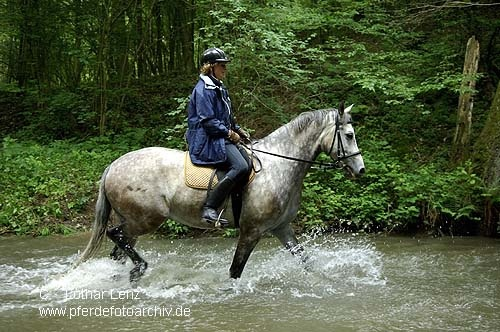

In [11]:
# Choose image to run, display it for reference
image = config['image']
display(filename=image) 

Foward time:  0.20293521881103516
horse : xmin 59 ymin 107 xmax 370 ymax 286
person : xmin 187 ymin 44 xmax 254 ymax 229


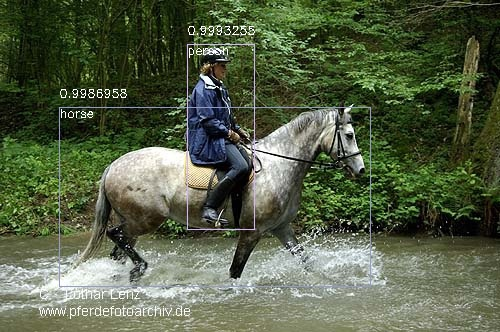

In [12]:
Detect("xfdnn_auto_cut_deploy.prototxt", config["caffemodel"], config["image"], config["labelmap_file"], config)
display(filename='res_det.jpg') 

# Conclusion
This notebook demonstrates how to target Xilinx FPGAs for inference using Caffe.  
When the time comes to take your application to production please look at examples in /workspace/ml-suite/examples/deployment_modes/  
Highest performance is acheived by creating multiprocess pipelines.